In [103]:
# Load Libraries
import pandas as pd
import numpy as np

### Load Data

In [104]:
# Load data to a DataFrame
beanDF = pd.read_excel('DryBeanDataset/Dry_Bean_Dataset.xlsx')

In [105]:
beanDF.shape

(13611, 17)

In [106]:
# See the relative numbers of each target category
beanDF.value_counts('Class')

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
dtype: int64

In [107]:
df = beanDF.copy()

### Drop Features

#### Lowest Variance

"When you do feature selection by variance threshold, you should scale the features first, as variance depends on the values of the features themselves." -Prof. Werner

In [108]:
# Load libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Create scaler
minmax_scale = MinMaxScaler(feature_range=(0,1))

# Scale features
scaled_features = minmax_scale.fit_transform(features)

# Create thresholder
thresholder = VarianceThreshold()

# Create high-variance feature matrix
features_high_variance = thresholder.fit_transform(scaled_features)

# Look at features, sorted by variance (highest to lowest)
d = {'Column': features.columns, 'Variance': thresholder.fit(scaled_features).variances_}
varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
varianceDF

,Column,Variance
13,ShapeFactor2,0.036926
11,Compactness,0.031678
4,AspectRation,0.030804
14,ShapeFactor3,0.030760
8,Extent,0.024929
2,MajorAxisLength,0.023817
12,ShapeFactor1,0.021609
1,Perimeter,0.021522
7,EquivDiameter,0.021022
3,MinorAxisLength,0.017733


In [109]:
# # Create thresholder
# thresholder = VarianceThreshold()
# # selector = VarianceThreshold()

# # Create high-variance feature matrix
# # features_high_variance = thresholder.fit_transform(features)
# features_high_variance = thresholder.fit_transform(scaled_features)

# # Look at features, sorted by variance (highest to lowest)
# # d = {'Column': beanDF.columns[:-1], 'Variance': thresholder.fit(features).variances_}
# d = {'Column': beanDF.columns[:-1], 'Variance': thresholder.fit(scaled_features).variances_}
# varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
# varianceDF

In [110]:
# thresholder.fit(scaled_features).variances_

In [111]:
features_high_variance

array([[0.03405267, 0.05857388, 0.04426214, ..., 0.83304879, 0.75099637,
        0.98061988],
       [0.03550018, 0.07755673, 0.03047881, ..., 0.96731548, 0.88498696,
        0.97497943],
       [0.03825855, 0.06803484, 0.05263303, ..., 0.80094229, 0.7361995 ,
        0.98719587],
       ...,
       [0.09273856, 0.16060492, 0.17638393, ..., 0.42701895, 0.4722397 ,
        0.9430251 ],
       [0.09277272, 0.16365701, 0.17970258, ..., 0.41532999, 0.45691893,
        0.91334231],
       [0.09282396, 0.16944765, 0.20088207, ..., 0.34689166, 0.36476185,
        0.9701623 ]])

In [112]:
d

{'Column': Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
        'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
        'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
        'ShapeFactor3', 'ShapeFactor4'],
       dtype='object'),
 'Variance': array([0.01567684, 0.02152226, 0.02381659, 0.01773331, 0.03080397,
        0.01765047, 0.01506503, 0.02102217, 0.02492898, 0.00381687,
        0.01410914, 0.03167777, 0.02160911, 0.0369258 , 0.03076003,
        0.00703828])}

In [113]:
# ## LOOK FOR FEATURES WITH LOW VARIANCE 
# # (i.e. containing little information)

# # Load libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import scale
# from sklearn.feature_selection import VarianceThreshold

# # Create features and target
# features = beanDF.select_dtypes(include='number')
# target = beanDF.Class

# # Standardize feature matrix
# # scaler = StandardScaler(with_std=False)#with_mean=False)
# features_std = scale(features, with_std=False, with_mean=False)
# # features_std = scaler.fit_transform(features)

# # Create thresholder
# thresholder = VarianceThreshold(threshold=0.5)
# # selector = VarianceThreshold()

# # Create high-variance feature matrix
# # features_high_variance = thresholder.fit_transform(features)
# features_high_variance = thresholder.fit_transform(features_std)

# # Look at features, sorted by variance (highest to lowest)
# # d = {'Column': beanDF.columns[:-1], 'Variance': thresholder.fit(features).variances_}
# d = {'Column': beanDF.columns[:-1], 'Variance': thresholder.fit(features_std).variances_}
# varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
# varianceDF

In [114]:
# features_std

In [115]:
# features_high_variance.variances_

In [116]:
# ## LOOK FOR FEATURES WITH LOW VARIANCE 
# # (i.e. containing little information)

# # Load libraries
# from sklearn.feature_selection import VarianceThreshold

# # Create features and target
# features = beanDF.select_dtypes(include='number')
# target = beanDF.Class

# # Create thresholder
# thresholder = VarianceThreshold(threshold=0.5)

# # Create high-variance feature matrix
# features_high_variance = thresholder.fit_transform(features)

# # Look at features, sorted by variance (highest to lowest)
# d = {'Column': beanDF.columns[:-1], 'Variance': thresholder.fit(features).variances_}
# varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
# varianceDF

In [147]:
# Make a list of columns with variance less than 10e-2
low_var = varianceDF['Column'][(varianceDF['Variance'] < 1.6e-2)].tolist()

# Features to drop
print("Features with low variance:\n", low_var)

Features with low variance:
 ['Area', 'ConvexArea', 'roundness', 'ShapeFactor4', 'Solidity']


#### Drop low_var:

In [118]:
# beanDF.drop(columns=low_var, inplace=True)
# beanDF.columns

#### Highly Correlated

In [119]:
## LOOK AT HIGHLY CORRELATED FEATURES
# (i.e. likely to be redundant)

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                 k=1).astype(np.bool))

# Find index of feature columns with high correlation
hi_corr = [column for column in upper.columns if any(upper[column] > 0.99)]

# Features to drop
print("Features with high correlation:\n", hi_corr)

Features with high correlation:
 ['ConvexArea', 'EquivDiameter', 'ShapeFactor3']


#### Drop hi_corr:

In [120]:
# beanDF.drop(columns=hi_corr, inplace=True)
# beanDF.columns

#### Most Informative

In [121]:
len(beanDF.columns)

17

In [142]:
## USE CHI-SQUARED TO FIND THE MOST INFORMATIVE FEATURES

# Load libraries
# from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectPercentile

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Select top 75% of features with highest F-values
fvalue_selector = SelectPercentile(f_classif, percentile=75)
features_kbest = fvalue_selector.fit_transform(features, target)

# Look at first row of best features
features_kbest[0]

array([2.83950000e+04, 6.10291000e+02, 2.08178117e+02, 1.73888747e+02,
       1.19719142e+00, 5.49812187e-01, 2.87150000e+04, 1.90141097e+02,
       9.13357755e-01, 7.33150614e-03, 3.14728917e-03, 8.34222388e-01])

In [143]:
len(features.columns[~features.iloc[0].isin(features_kbest[0])].tolist())

4

In [123]:
features.index

RangeIndex(start=0, stop=13611, step=1)

In [124]:
features.iloc[0].index

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [125]:
# Compare to first row of all features
features.iloc[0]

Area               28395.000000
Perimeter            610.291000
MajorAxisLength      208.178117
MinorAxisLength      173.888747
AspectRation           1.197191
Eccentricity           0.549812
ConvexArea         28715.000000
EquivDiameter        190.141097
Extent                 0.763923
Solidity               0.988856
roundness              0.958027
Compactness            0.913358
ShapeFactor1           0.007332
ShapeFactor2           0.003147
ShapeFactor3           0.834222
ShapeFactor4           0.998724
Name: 0, dtype: float64

In [126]:
# Check which features are in the kbest features
features.iloc[0].isin(features_kbest[0])

Area                True
Perimeter           True
MajorAxisLength     True
MinorAxisLength     True
AspectRation        True
Eccentricity        True
ConvexArea          True
EquivDiameter       True
Extent             False
Solidity           False
roundness           True
Compactness         True
ShapeFactor1        True
ShapeFactor2        True
ShapeFactor3        True
ShapeFactor4       False
Name: 0, dtype: bool

In [127]:
features.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [128]:
len(features.columns)

16

In [145]:
# Make a list of the low information features
low_inf = features.columns[~features.iloc[0].isin(features_kbest[0])].tolist()

# Features to drop
print("Features with low information:\n", low_inf)

Features with low information:
 ['Extent', 'Solidity', 'roundness', 'ShapeFactor4']


#### Drop low_inf:

In [130]:
# # Drop low information features
# beanDF.drop(columns=low_inf, inplace=True)
# beanDF.columns

#### Features to drop:

In [148]:
low_var

['Area', 'ConvexArea', 'roundness', 'ShapeFactor4', 'Solidity']

In [132]:
hi_corr

['ConvexArea', 'EquivDiameter', 'ShapeFactor3']

In [146]:
low_inf

['Extent', 'Solidity', 'roundness', 'ShapeFactor4']

In [22]:
# # Drop feature
# subsetDF.drop(columns=hi_corr, inplace=True)
# subsetDF.columns

Index(['MinorAxisLength', 'AspectRation', 'Compactness', 'ShapeFactor1',
       'ShapeFactor2', 'Class'],
      dtype='object')

### Histograms

In [33]:
# Load libraries
import matplotlib.pyplot as plt

In [34]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

In [35]:
def makeHistogram(var, df=beanDF):
    # Create a histogram from a DataFrame variable
    plt.hist(df[var], bins=40)
    plt.xlabel(var, fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

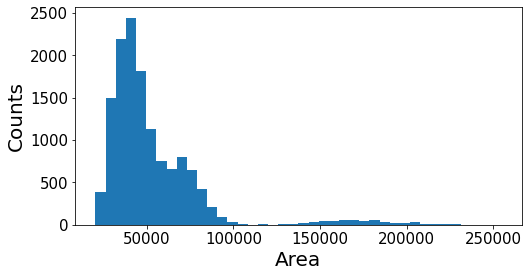

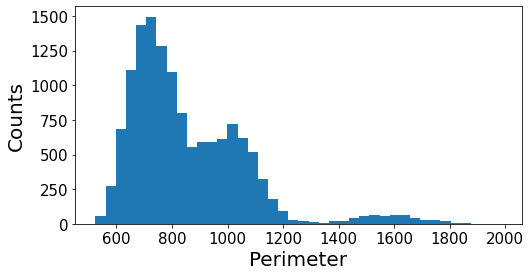

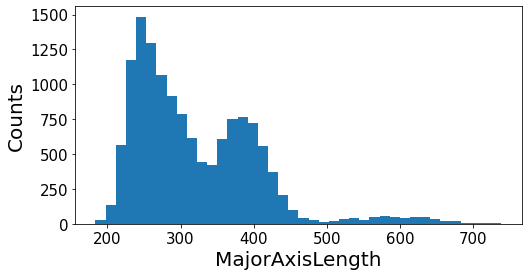

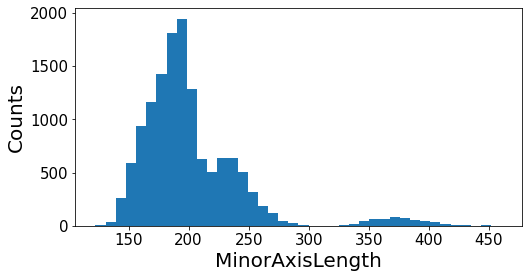

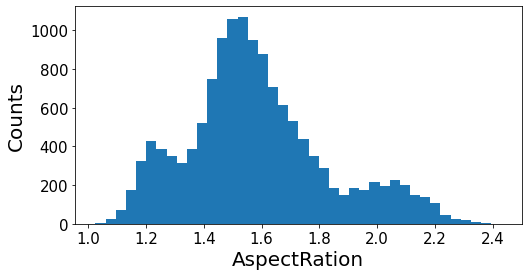

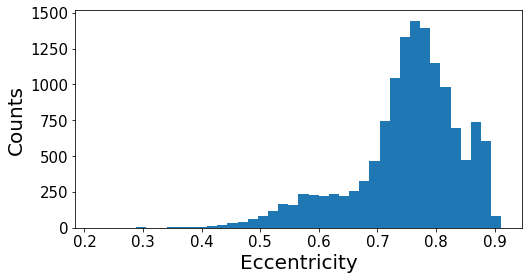

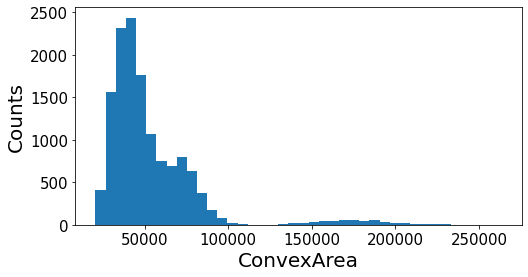

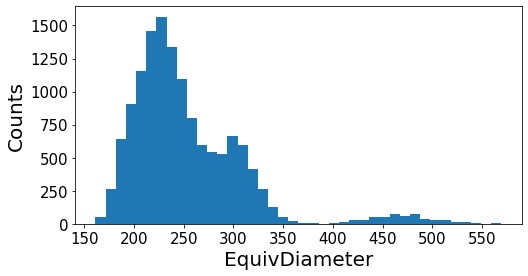

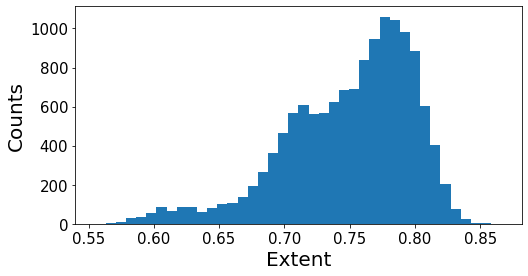

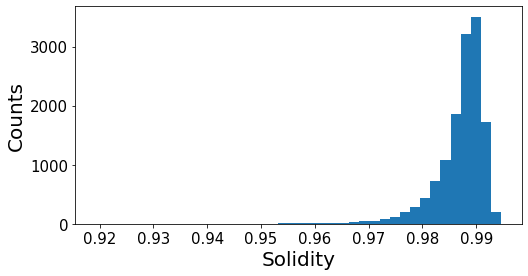

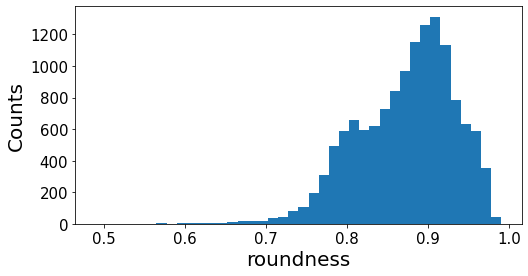

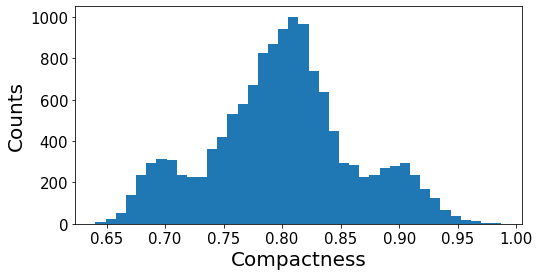

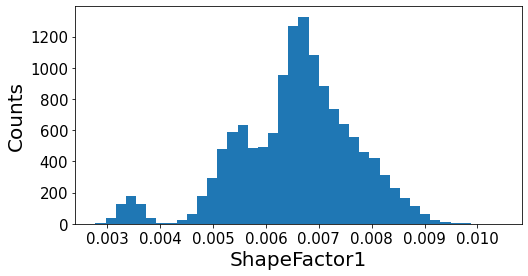

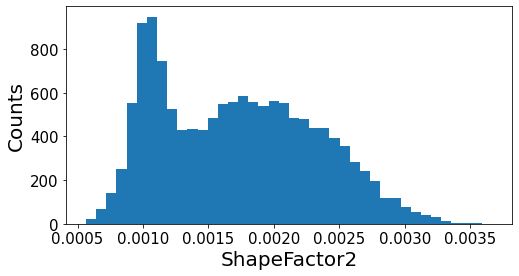

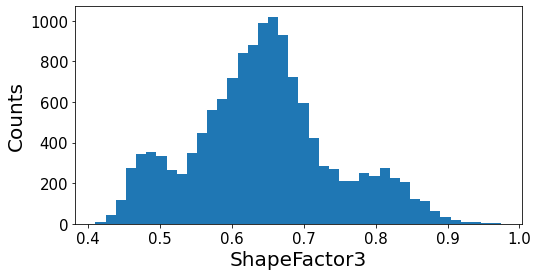

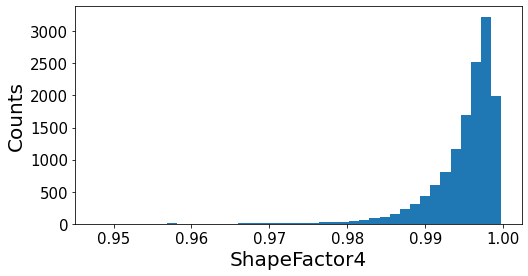

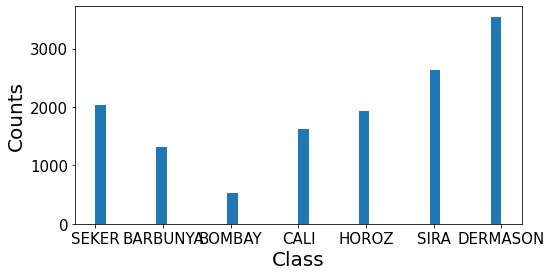

In [36]:
# Iterate through columns to get a quick look
# at the distribution of each variable
for item in beanDF.columns:
    makeHistogram(item)

### Transformations

#### Log(10)

In [37]:
# Create a new DataFrame for data transformations
transformDF = beanDF.copy()

In [38]:
# Features with large right skew (> 1)
transformDF.skew()[transformDF.skew() > 1]

Area               2.952931
Perimeter          1.626124
MajorAxisLength    1.357815
MinorAxisLength    2.238211
ConvexArea         2.941821
EquivDiameter      1.948958
dtype: float64

In [39]:
# Get a list of the columns for log-transformation
pos_skew = transformDF.skew()[transformDF.skew() > 1].index.tolist()
pos_skew

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'ConvexArea',
 'EquivDiameter']

In [40]:
# Apply a log10-tranformation to right-skewed columns
for item in pos_skew:
    transformDF[item] = np.log10(transformDF[item])

#### Cube

In [41]:
# Features with large left skew (< -1)
transformDF.skew()[transformDF.skew() < -1]

Eccentricity   -1.062824
Solidity       -2.550093
ShapeFactor4   -2.759483
dtype: float64

In [42]:
# Get a list of the columns for cube tranformation
neg_skew = transformDF.skew()[transformDF.skew() < -1].index.tolist()
neg_skew

['Eccentricity', 'Solidity', 'ShapeFactor4']

In [43]:
# Apply a cube-tranformation to left-skewed columns
for item in neg_skew:
    transformDF[item] = transformDF[item]**3

In [44]:
transformDF

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,4.453242,2.785537,2.318435,2.240271,1.197191,0.166205,4.458109,2.279076,0.763923,0.966939,0.958027,0.913358,0.007332,0.003147,0.834222,0.996177,SEKER
1,4.458396,2.804833,2.302168,2.261820,1.097356,0.069825,4.464966,2.281653,0.783968,0.955630,0.887034,0.953861,0.006979,0.003564,0.909851,0.995298,SEKER
2,4.468052,2.795261,2.328025,2.245343,1.209713,0.178194,4.472610,2.286481,0.778113,0.969002,0.947849,0.908774,0.007244,0.003048,0.825871,0.997201,SEKER
3,4.477237,2.810155,2.323372,2.261302,1.153638,0.123965,4.487478,2.291074,0.782681,0.931704,0.903936,0.928329,0.007017,0.003215,0.861794,0.982697,SEKER
4,4.479143,2.792486,2.305024,2.279391,1.060798,0.037153,4.483116,2.292027,0.773098,0.972928,0.984877,0.970516,0.006697,0.003665,0.941900,0.997500,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,4.624251,2.880640,2.460479,2.269384,1.552728,0.447701,4.628471,2.364581,0.714574,0.971273,0.916603,0.801865,0.006858,0.001749,0.642988,0.995164,DERMASON
13607,4.624292,2.879382,2.449596,2.280381,1.476439,0.398205,4.628328,2.364601,0.799943,0.972511,0.922015,0.822252,0.006688,0.001886,0.676099,0.994665,DERMASON
13608,4.624684,2.880425,2.449540,2.281461,1.472582,0.395552,4.629093,2.364797,0.729932,0.970001,0.918424,0.822730,0.006681,0.001888,0.676884,0.990333,DERMASON
13609,4.624767,2.882968,2.452373,2.279383,1.489326,0.406959,4.630092,2.364838,0.705389,0.963882,0.907906,0.817457,0.006724,0.001852,0.668237,0.985736,DERMASON


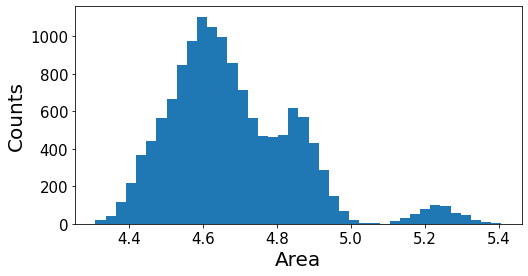

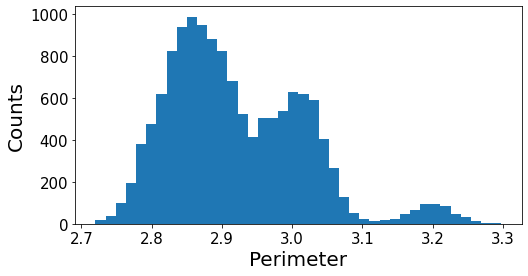

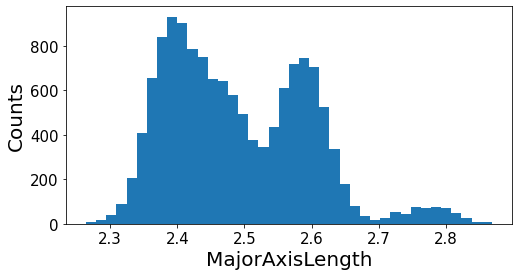

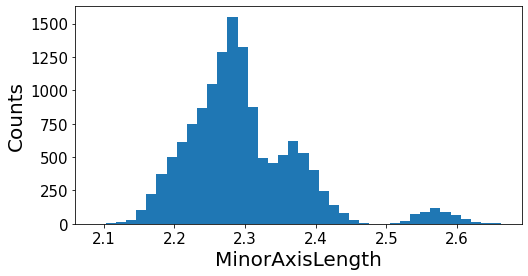

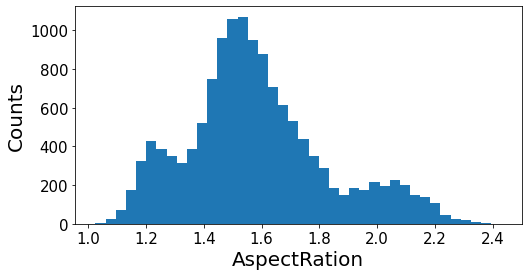

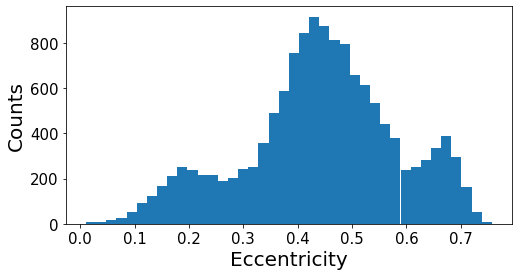

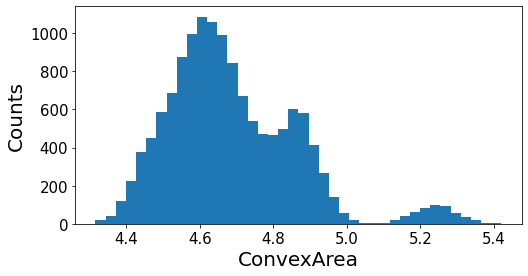

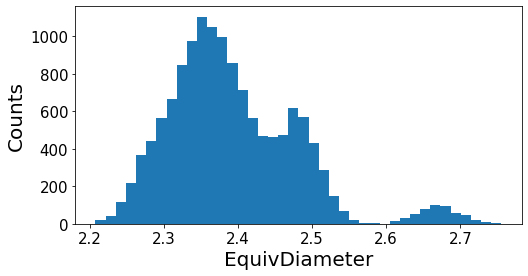

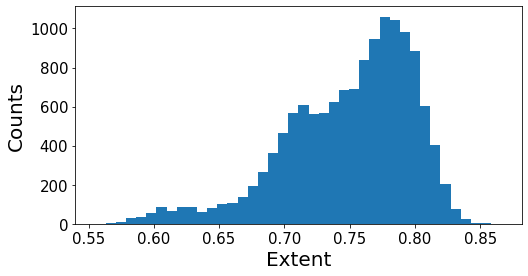

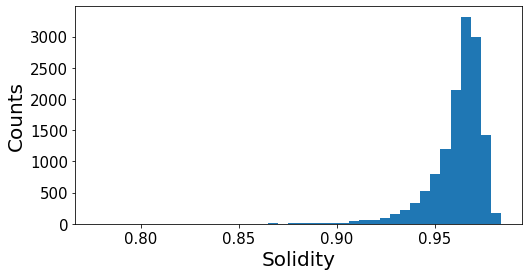

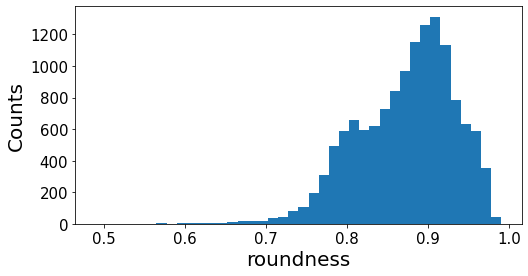

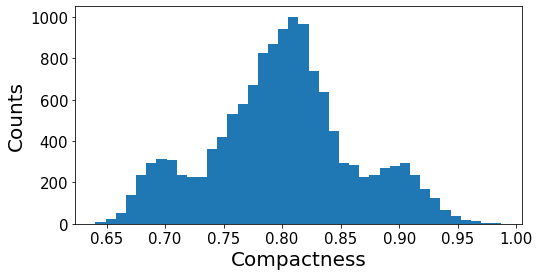

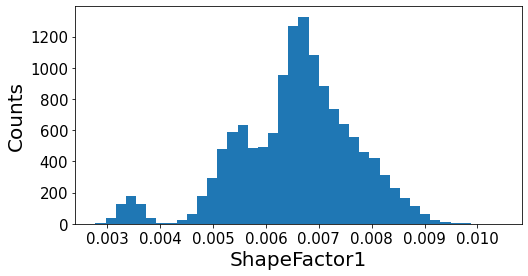

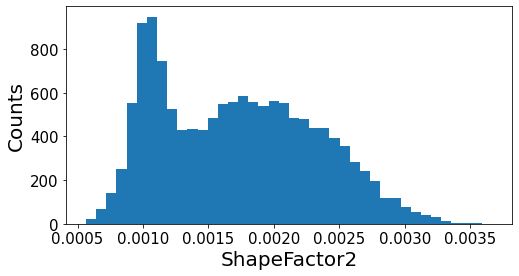

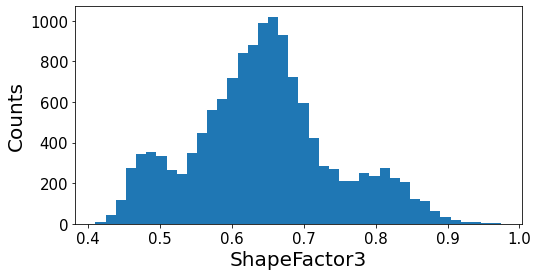

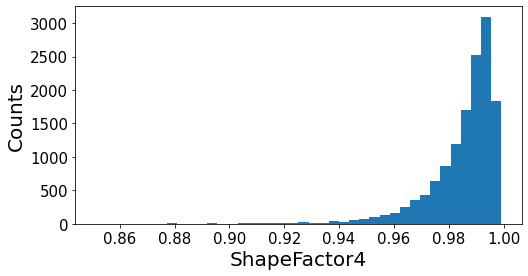

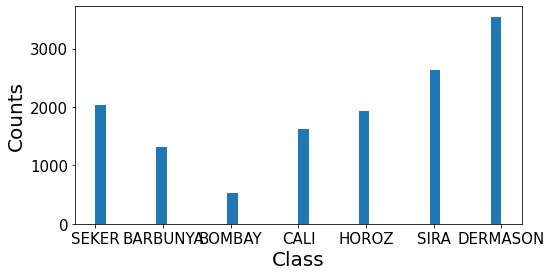

In [45]:
# Iterate through columns to get a quick look
# at the distribution of each variable
for item in transformDF.columns:
    makeHistogram(item, df=transformDF)

### Create Dummy Variables

#### Encode Target Variable

In [46]:
## ENCODE CATEGORICAL TARGET COLUMN

# Load libraries
from sklearn.preprocessing import OrdinalEncoder

# Set up encoder
ord_enc = OrdinalEncoder()

# Create coded column
# beanDF['Class_Coded'] = ord_enc.fit_transform(beanDF[['Class']])
class_encoded = ord_enc.fit_transform(transformDF[['Class']])

In [47]:
class_encoded

array([[5.],
       [5.],
       [5.],
       ...,
       [3.],
       [3.],
       [3.]])

#### Create Dummy Variables from Target Variable

NOT THIS:

In [48]:
# ## CREATE DUMMY VARIABLES FROM CATEGORICAL COLUMN

# # Load libraries
# from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer

# # Use feature from a previous step
# # target

# # Create one-hot encoder
# one_hot = LabelBinarizer()

# # One-hot encode feature
# class_dummies = one_hot.fit_transform(transformDF.Class)
# class_dummies

In [49]:
# # View feature classes
# one_hot.classes_

THIS:

In [50]:
# Get the categorical data
cat_features = ['Class']
class_df = transformDF[cat_features]
# catDF = catDF.replace({'Pclass': {1: '1st', 2: '2nd', 3: '3rd'}})

In [51]:
# One Hot Encoding 
class_dummies = pd.get_dummies(class_df)

In [52]:
# Check the data
class_dummies.head()

,Class_BARBUNYA,Class_BOMBAY,Class_CALI,Class_DERMASON,Class_HOROZ,Class_SEKER,Class_SIRA
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0


## Training

### Split Data into Training and Testing Sets

In [53]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [54]:
# Combine the numerical features and the dummy features together
features_model = transformDF.columns[:-1].tolist()
# data_model_X = pd.concat([transformDF[features_model], class_dummies], axis=1)
data_model_X = transformDF[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
# data_model_y = class_dummies
# data_model_y = class_encoded
data_model_y = transformDF.Class
# data_model_y = df.replace({'Survived': {1: 'Survived', 0: 'Not_survived'}})['Survived']

Separate data into training and validation and check the details of the datasets

In [55]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=11)

In [56]:
# Number of samples in each set
print(f"No. of samples in training set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

No. of samples in training set: 9527
No. of samples in validation set: 4084


In [57]:
# Survived and not-survived
print(f'No. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [58]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [59]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

In [60]:
# transformDF.Class.unique().tolist()

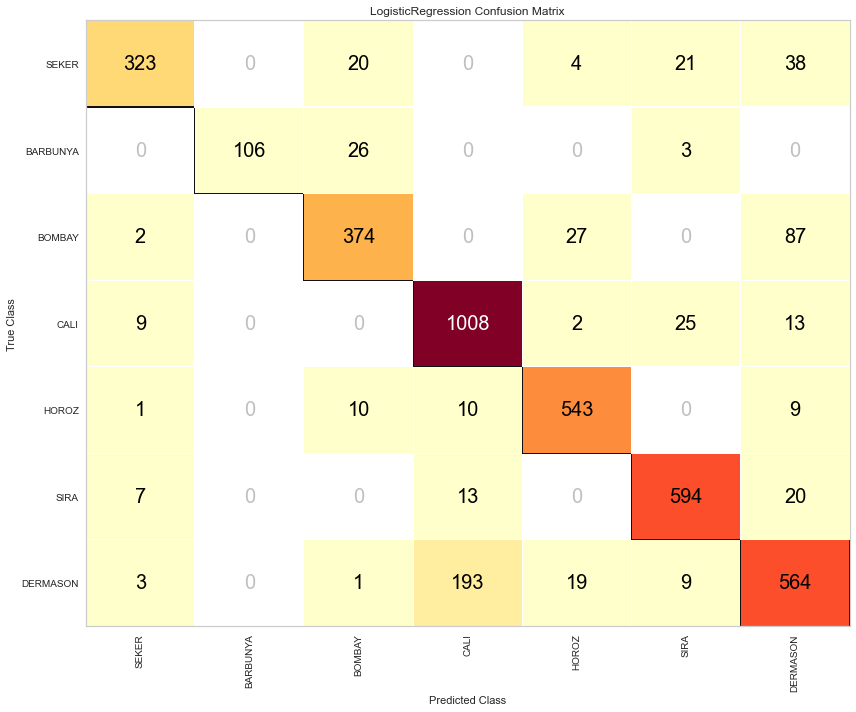

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [61]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear') #multi_class='auto', penalty='l2'

# The ConfusionMatrix visualizer taxes a model
# classes = ['Not_survived', 'Survived']
classes = transformDF.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

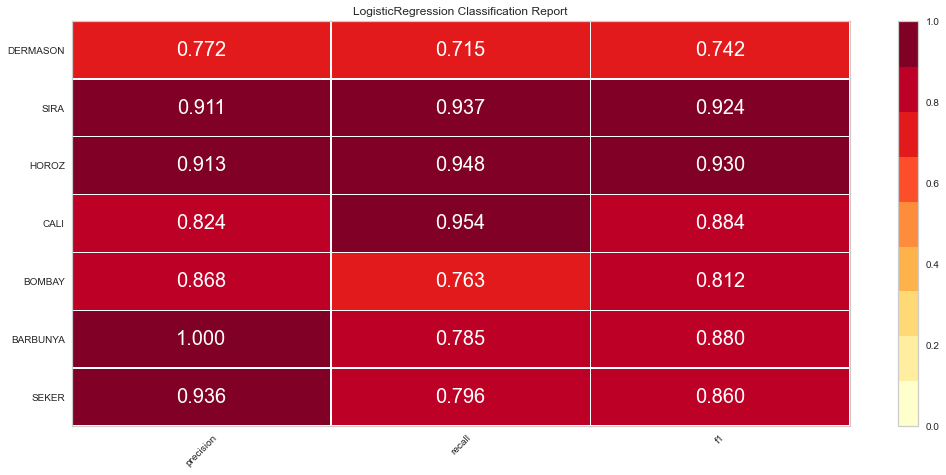

In [62]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

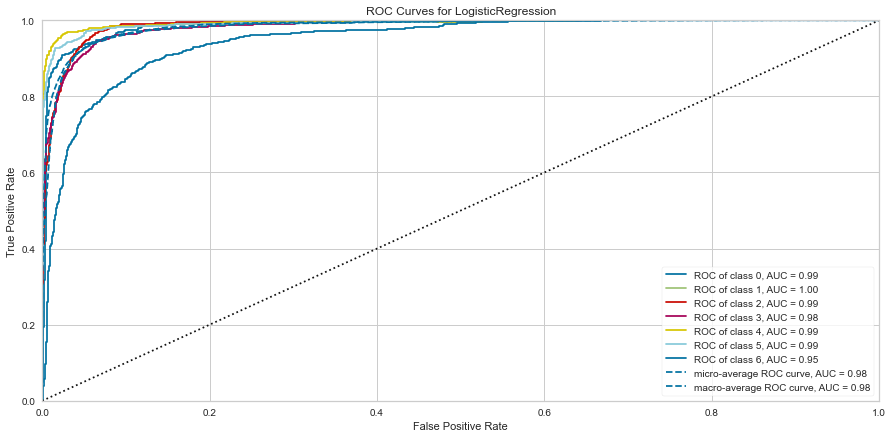

In [63]:
## ROC and AUC

# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model) # classes=['Not_survived', 'Survived']

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

## Training

### Split Data into Training and Testing Sets

In [64]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [65]:
# Combine the numerical features and the dummy features together
features_model = beanDF.columns[:-1].tolist()
# data_model_X = pd.concat([transformDF[features_model], class_dummies], axis=1)
data_model_X = beanDF[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
# data_model_y = class_dummies
# data_model_y = class_encoded
data_model_y = beanDF.Class
# data_model_y = df.replace({'Survived': {1: 'Survived', 0: 'Not_survived'}})['Survived']

Separate data into training and validation and check the details of the datasets

In [66]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=11)

In [67]:
# Number of samples in each set
print(f"No. of samples in training set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

No. of samples in training set: 9527
No. of samples in validation set: 4084


In [68]:
# Survived and not-survived
print(f'No. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [69]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [70]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

In [71]:
# transformDF.Class.unique().tolist()

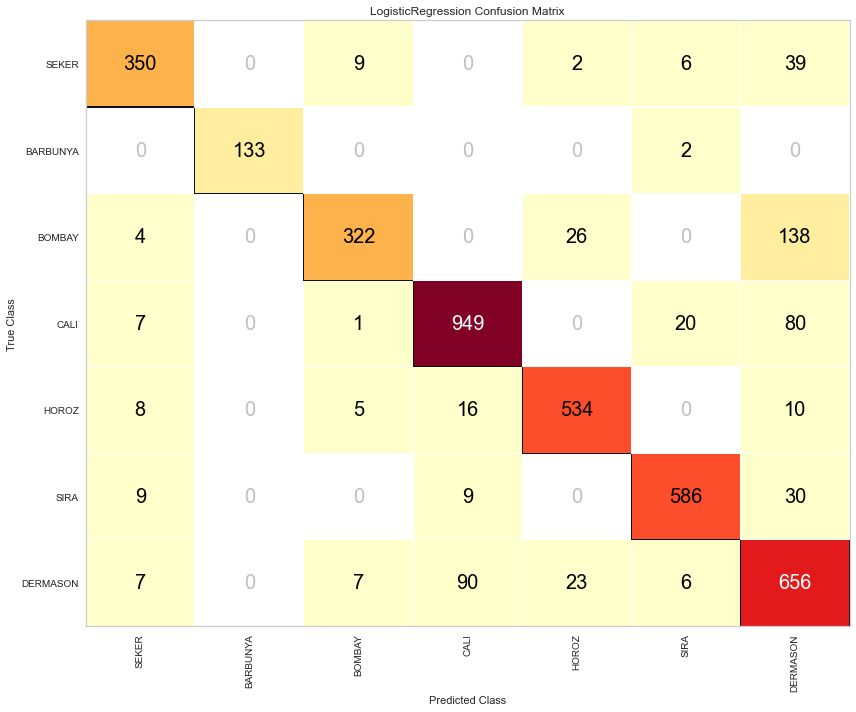

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [72]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear') #multi_class='auto', penalty='l2'

# The ConfusionMatrix visualizer taxes a model
# classes = ['Not_survived', 'Survived']
classes = beanDF.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

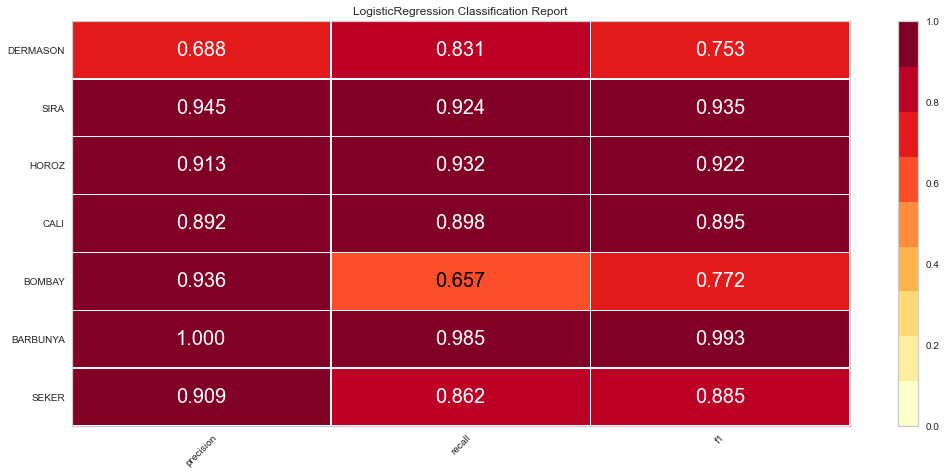

In [73]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

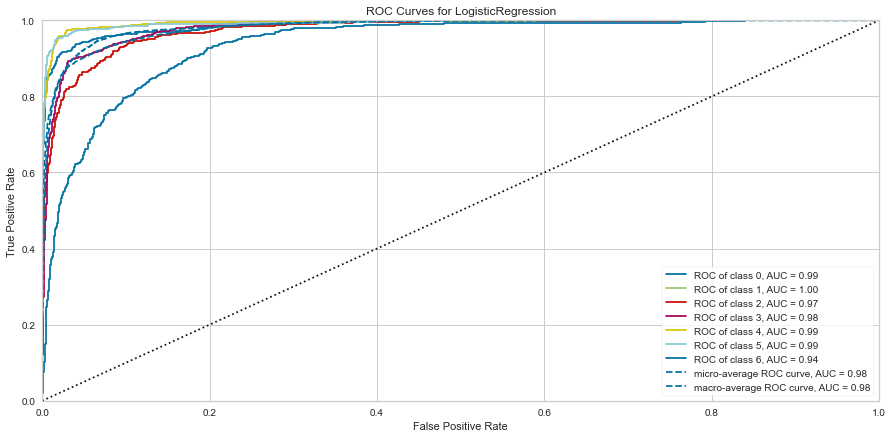

In [74]:
## ROC and AUC

# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model) # classes=['Not_survived', 'Survived']

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

## Recursively Eliminate Features
Machine Learning w/Python Cookbook, section 10.5

In [75]:
# Load libraries
import warnings
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn import datasets, linear_model

In [76]:
testDF = beanDF.copy()

In [77]:
## ENCODE CATEGORICAL TARGET COLUMN

# Load libraries
from sklearn.preprocessing import OrdinalEncoder

# Set up encoder
ord_enc = OrdinalEncoder()

# Create coded column
class_encoded = ord_enc.fit_transform(testDF[['Class']])

In [78]:
# Create features and target
features = testDF.select_dtypes(include='number')
target = class_encoded

In [79]:
# Create a linear regression
ols = linear_model.LinearRegression()

In [80]:
# Recursively eliminate features
rfecv = RFECV(estimator=ols, step=1, scoring="neg_mean_squared_error")
rfecv.fit(features, target)
rfecv.transform(features)

array([[0.00314729],
       [0.00356362],
       [0.00304773],
       ...,
       [0.00188827],
       [0.00185203],
       [0.00163981]])

In [81]:
# Number of best features
rfecv.n_features_

1

In [82]:
# Which categories are best
rfecv.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False])

In [83]:
# Rank features best (1) to worst
rfecv.ranking_

array([15, 13, 14, 11,  6,  8, 16, 12, 10,  5,  7,  3,  2,  1,  4,  9])

In [84]:
testDF.shape

(13611, 17)

In [85]:
testDF.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [86]:
len(features.columns)

16

In [87]:
len(rfecv.ranking_)

16

In [150]:
d = {'Features': features.columns, 'Rank': rfecv.ranking_}

In [151]:
d

{'Features': Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
        'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
        'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
        'ShapeFactor3', 'ShapeFactor4'],
       dtype='object'),
 'Rank': array([15, 13, 14, 11,  6,  8, 16, 12, 10,  5,  7,  3,  2,  1,  4,  9])}

In [152]:
df = pd.DataFrame(d)

In [153]:
df.sort_values('Rank')

,Features,Rank
13,ShapeFactor2,1
12,ShapeFactor1,2
11,Compactness,3
14,ShapeFactor3,4
9,Solidity,5
4,AspectRation,6
10,roundness,7
5,Eccentricity,8
15,ShapeFactor4,9
8,Extent,10


In [156]:
df.sort_values('Rank').tail(4)['Features'].tolist()

['Perimeter', 'MajorAxisLength', 'Area', 'ConvexArea']

In [13]:
# Make a list of the low information features
low_inf = features.columns[~features.iloc[0].isin(features_kbest[0])].tolist()

# Features to drop
print("Features with low information:\n", low_inf)

Features with low information:
 ['Eccentricity', 'Extent', 'Solidity', 'roundness', 'ShapeFactor4']


In [35]:
best_feat = df.Features.tolist()
best_feat

['ShapeFactor2',
 'ShapeFactor1',
 'Compactness',
 'ShapeFactor3',
 'Solidity',
 'AspectRation',
 'roundness',
 'Eccentricity',
 'ShapeFactor4',
 'Extent',
 'MinorAxisLength',
 'EquivDiameter',
 'Perimeter',
 'MajorAxisLength',
 'Area',
 'ConvexArea']

In [36]:
for f in to_drop:
    best_feat.remove(f)

In [37]:
best_feat

['ShapeFactor2',
 'ShapeFactor1',
 'Compactness',
 'ShapeFactor3',
 'AspectRation',
 'MinorAxisLength']

In [38]:
cols = best_feat + ['Class']

In [39]:
cols

['ShapeFactor2',
 'ShapeFactor1',
 'Compactness',
 'ShapeFactor3',
 'AspectRation',
 'MinorAxisLength',
 'Class']

In [40]:
testDF = subsetDF[cols]

In [41]:
testDF

,ShapeFactor2,ShapeFactor1,Compactness,ShapeFactor3,AspectRation,MinorAxisLength,Class
0,0.003147,0.007332,0.913358,0.834222,1.197191,173.888747,SEKER
1,0.003564,0.006979,0.953861,0.909851,1.097356,182.734419,SEKER
2,0.003048,0.007244,0.908774,0.825871,1.209713,175.931143,SEKER
3,0.003215,0.007017,0.928329,0.861794,1.153638,182.516516,SEKER
4,0.003665,0.006697,0.970516,0.941900,1.060798,190.279279,SEKER
...,...,...,...,...,...,...,...
13606,0.001749,0.006858,0.801865,0.642988,1.552728,185.944705,DERMASON
13607,0.001886,0.006688,0.822252,0.676099,1.476439,190.713136,DERMASON
13608,0.001888,0.006681,0.822730,0.676884,1.472582,191.187979,DERMASON
13609,0.001852,0.006724,0.817457,0.668237,1.489326,190.275731,DERMASON


In [42]:
## LOOK AT HIGHLY CORRELATED FEATURES
# (i.e. likely to be redundant)

# Create features and target
features = testDF.select_dtypes(include='number')
target = testDF.Class

# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                 k=1).astype(np.bool))

# Find index of feature columns with high correlation
hi_corr = [column for column in upper.columns if any(upper[column] > 0.99)]

# Features to drop
print("Features with high correlation:\n", hi_corr)

Features with high correlation:
 ['ShapeFactor3']


## 11

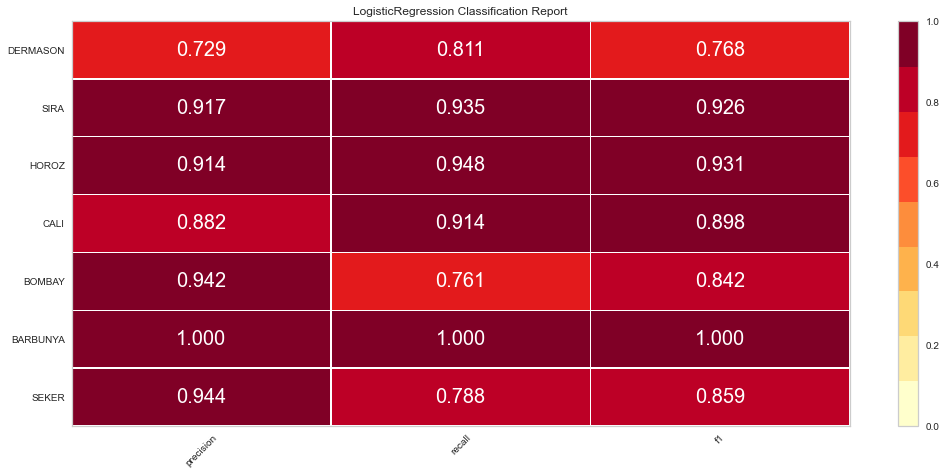

In [220]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

## 12 - BEST!

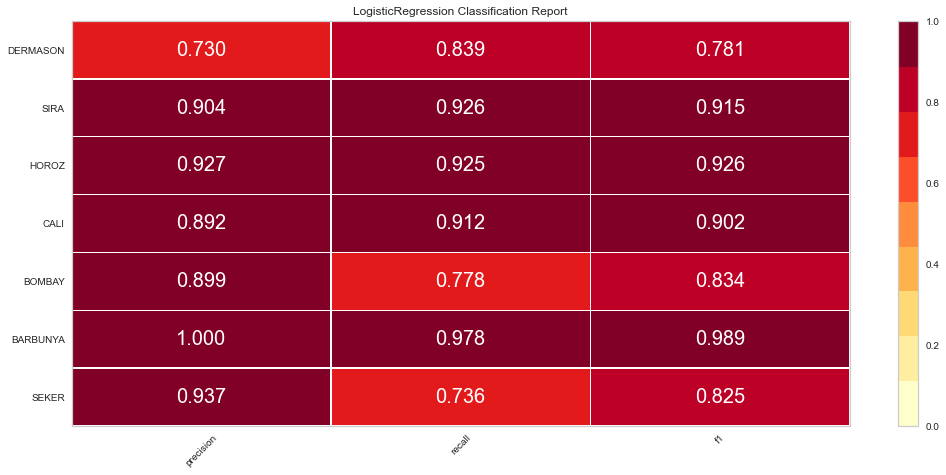

In [233]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

## 13

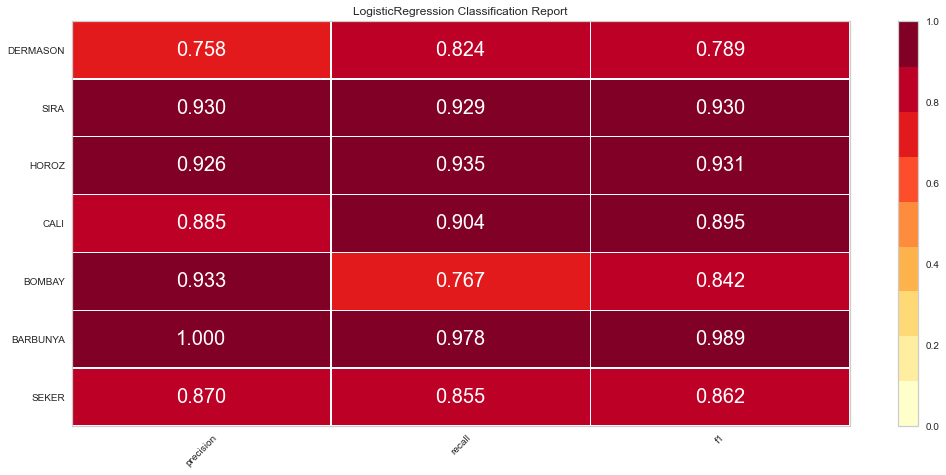

In [246]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

## 14

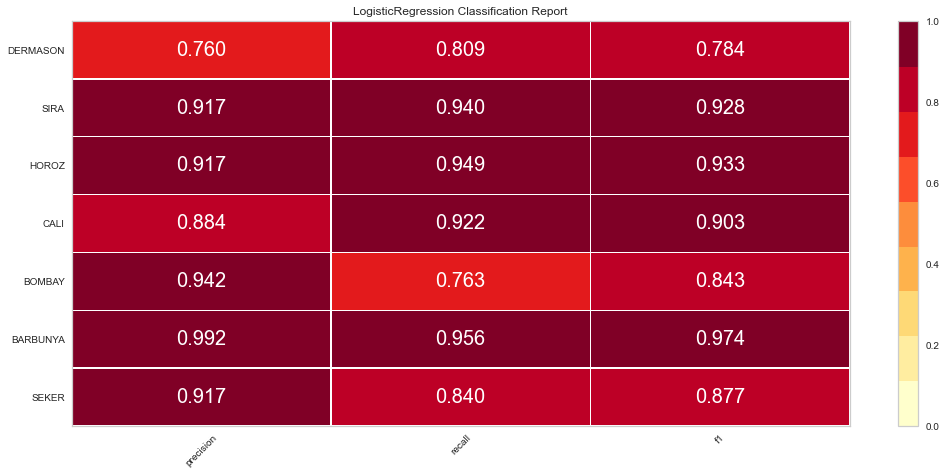

In [259]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

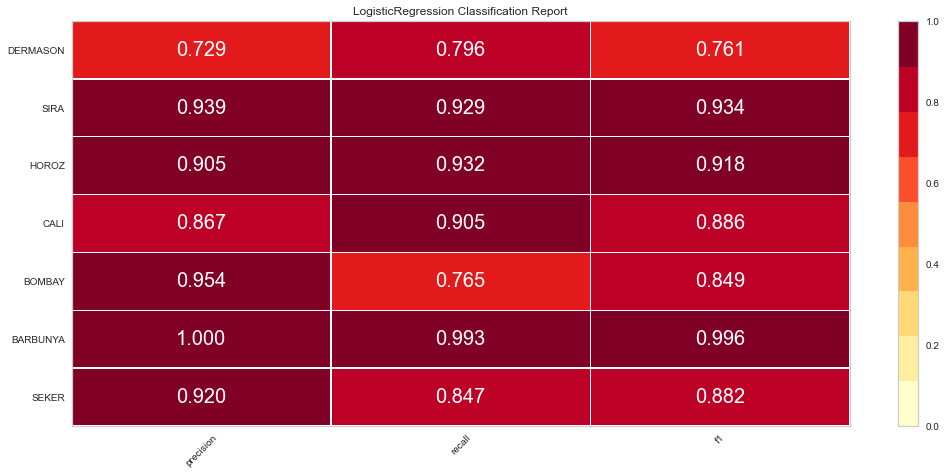

In [285]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

## 15